# Model Definition and Evaluation
## Table of Contents
1. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Hyperparameter Tuning](#hyperparameter-tuning)
4. [Implementation](#implementation)
5. [Evaluation Metrics](#evaluation-metrics)
6. [Comparative Analysis](#comparative-analysis)


In [2]:
%load_ext autoreload
%autoreload complete

import random
from pathlib import Path
import rich

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Subset
import pytorch_lightning as pl

import monai
from monai import transforms
import custom_transforms
from monai.data import Dataset, CacheDataset, DataLoader

from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from torchmetrics import MetricCollection
from torchmetrics.classification import (MulticlassAccuracy, MulticlassPrecision,
                                         MulticlassRecall, MulticlassF1Score,
                                         MulticlassConfusionMatrix)

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data import data_helper
from data.data_helper import Phase

sns.set_theme()
plt.rcParams["figure.figsize"] = 12, 8
monai.utils.set_determinism()

data_folder = '../data/train/'

## Model Selection

[Discuss the type(s) of models you consider for this task, and justify the selection.]



## Feature Engineering

[Describe any additional feature engineering you've performed beyond what was done for the baseline model.]


In [6]:
train_data = pd.DataFrame(data_helper.load_all_patients(data_folder, return_df=True)).reset_index()
mask_labels = ['RV', 'MC', 'LV']
class_labels = ['NOR', 'MINF', 'DCM', 'HCM', 'RV']

clabel2id_map = {value:key for key, value in enumerate(class_labels)}
train_data['label_id'] = train_data['label'].map(clabel2id_map)
train_data = train_data.to_dict('records')

In [32]:
train_data[:1]

[{'id': 'p0001',
  'label': 'NOR',
  'sys': WindowsPath('../data/train/p0001/p0001_frame01.nii.gz'),
  'sys_seg': WindowsPath('../data/train/p0001/p0001_frame01_gt.nii.gz'),
  'dia': WindowsPath('../data/train/p0001/p0001_frame06.nii.gz'),
  'dia_seg': WindowsPath('../data/train/p0001/p0001_frame06_gt.nii.gz'),
  'label_id': 0}]

tensor([177.5805,   0.0000,   0.0000])
tensor([177.5805,   0.0000,   0.0000])
['img', 'seg', 'label', 'label_id', 'id']
Subject: p0003
Shape: torch.Size([2, 15, 80, 77])


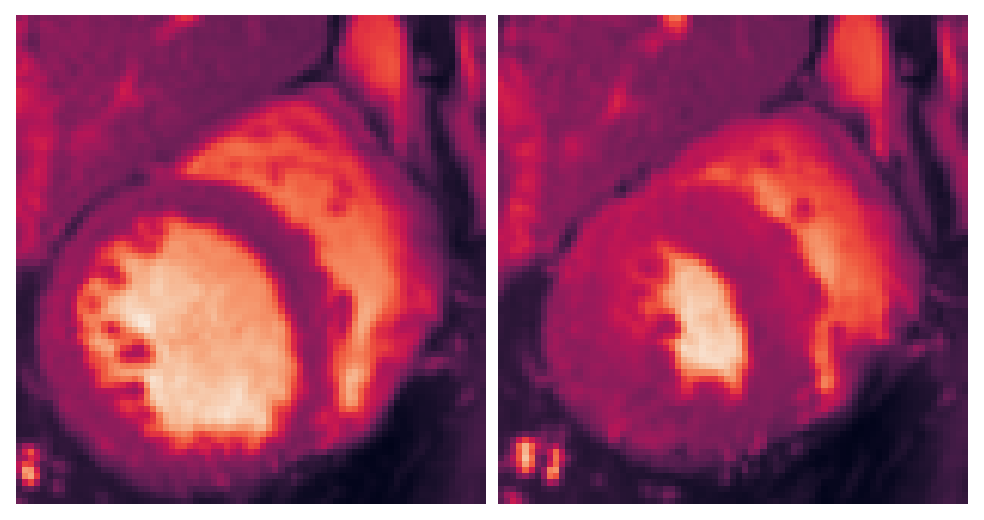

In [33]:
trfm = transforms.Compose([
    transforms.LoadImaged(['sys', 'sys_seg', 'dia', 'dia_seg'],
                          image_only=False, ensure_channel_first=True),
    # concat the two input images / seg masks as channels
    transforms.ConcatItemsd(['sys', 'dia'], name='img', dim=0),
    transforms.ConcatItemsd(['sys_seg', 'dia_seg'], name='seg', dim=0),
    transforms.DeleteItemsd(['sys', 'dia', 'sys_seg', 'dia_seg']),
    # normalize the orientation in space
    transforms.Orientationd(['img','seg'], 'SPL'),
    custom_transforms.EllipseFitRotated(['img','seg'], mask_key='seg', depth_axis=0, rot90_only=False),
    # crop the images to the bounding box given by the seg mask
    transforms.CropForegroundd(["img", "seg"], source_key="seg",
                                     select_fn=lambda x: x > 0, allow_smaller=False),
    # normalize intensity between images and scale to [0,1]
    # custom_transforms.AdaptiveHistogramNormalized(['img'], clip_limit=.01),
    #transforms.HistogramNormalized(['img'], mask_key='seg'),
    # use the segmentations to mask the images - this will result in 1 channel per label
    #custom_transforms.MultiMaskIntensityd(keys=['img'], mask_key='seg', select_labels=[1,2,3]),
    # alternative just mask out the background
    # transforms.MaskIntensityd(keys=['img'], mask_key='seg'),
    transforms.SelectItemsD(['img', 'seg', 'label', 'label_id', 'id']),# 'seg']),
    transforms.Spacingd(['img', 'seg'], pixdim=(5, 1.5, 1.5)),
    #transforms.Resized(['img'], spatial_size=(16, 64, 64)),
    # transforms.ResizeWithPadOrCropd(['img', 'seg'], spatial_size=(20, 100, 100), allow_missing_keys=True),
    #transforms.RandRotate90d(['img', 'seg'], spatial_axes=(1,2)),
])

#data = random.choice(train_data)
data = train_data[2]
data_trans = trfm(data)
#data = trfm(train_data[0])
print(list(data_trans.keys()))
print(f"Subject: {data_trans['id']}")
# print(f"True label: {data_trans['label_id']} ({data_trans['label']})")
print("Shape:", data_trans['img'].shape)
n = data_trans['img'].shape[1]
monai.visualize.matshow3d(data_trans['img'][:, n//2])
#monai.visualize.matshow3d(data_trans['seg'][:, n//2]);
plt.show()
# TODO: is there a missing mask in dia frame 0?

## Implementation

First we need a DataModule to load the data, preprocess it and serve batches to our model.
As seen above Monai already implements a lot of the transformations needed. Three custom ones are implemented for the more specialised processings.
To test the optimal preprocessing the class is configurable by a lot of parameter settings.

In [3]:
class MRIDataModule(pl.LightningDataModule):
    def __init__(self, data_folder, batch_size, train_val_ratio=0.8, use_cache=True,
                 orient='SPL', crop_foreground=True, register_heart_axis=False,
                 intensity_norm='adaptive', mask_intensity=None, clip_percentiles=(0.5,99.5),
                 spacing=(5,2,2), use_pad=False, spatial_size=None, augmentations=None, concat_dim=0):
        super().__init__()
        self.batch_size = batch_size
        self.data_folder = Path(data_folder)
        self.train_val_ratio = train_val_ratio
        self.use_cache = use_cache
        self.orient = orient
        self.crop_foreground = crop_foreground
        self.register_heart_axis = register_heart_axis
        self.intensity_norm = intensity_norm
        self.mask_intensity = mask_intensity
        self.clip_percentiles = clip_percentiles
        self.spacing = spacing
        self.use_pad = use_pad
        self.spatial_size = (spatial_size if spatial_size is not None
                             else self._recommended_spatial_size())
        self.concat_dim = concat_dim

        self.labels = ['NOR', 'MINF', 'DCM', 'HCM', 'RV']
        self.n_classes = len(self.labels)

        self.save_hyperparameters()

        # basic loading transforms
        transform = [
            transforms.ToTensord(['label'], allow_missing_keys=True),
            ## load the 3D-Tensors with their corresponding segmentations masks from nii.gz format
            transforms.LoadImaged(keys=['sys', 'sys_seg', 'dia', 'dia_seg'], ensure_channel_first=True),
            ## concat the two input images / seg masks as channels
            transforms.ConcatItemsd(keys=['sys', 'dia'], name='img', dim=concat_dim),
            transforms.ConcatItemsd(keys=['sys_seg', 'dia_seg'], name='seg', dim=concat_dim),
            transforms.DeleteItemsd(['sys', 'dia', 'sys_seg', 'dia_seg']),
            ## normalize the orientation in space
            transforms.Orientationd(keys=['img','seg'], axcodes='SPL'),
            ## some images are rotated and have wrong metadata --> complicated fix
            custom_transforms.EllipseFitRotated(['img','seg'], mask_key='seg', depth_axis=0,
                                                rot90_only=(not register_heart_axis)),
        ]

        if clip_percentiles is not None and len(clip_percentiles) == 2:
            ## perform soft clipping of the given low and high percentile
            transform.append(transforms.ClipIntensityPercentilesd(['img'], *clip_percentiles, sharpness_factor=5))

        ## normalize intensity between images and scale to [0,1]
        if intensity_norm == 'linear':
            # linearly scale to [0,1] - clipping via clip_percentile is recommended
            transform.append(transforms.ScaleIntensityd(['img'], channel_wise=True))
        if intensity_norm == 'znorm':
            # linearly scale to [0,1] - clipping via clip_percentile is recommended
            transform.append(transforms.NormalizeIntensity(['img'], channel_wise=True))
        elif intensity_norm == 'histogram':
            # use Histogram Normalization for scaling - clipping via clip_percentile is recommended
            transform.append(transforms.HistogramNormalized(['img'], min=0, max=1))
        elif intensity_norm == 'adaptive':
            # use sklearn's Adaptive Histogram Normalization (CLAHE) - clipping is not necessary
            transform.append(custom_transforms.AdaptiveHistogramNormalized(['img']))

        if crop_foreground:
            ## crop the images to the bounding box given by the seg mask
            transform.append(transforms.CropForegroundd(keys=['img', 'seg'], source_key='seg', allow_smaller=False),)

        if mask_intensity == 'single':
            self.n_channels = 2
            transform.append(transforms.MaskIntensityd(['img'], mask_key='seg'))
        elif mask_intensity == 'multi':
            self.n_channels = 6
            transform.append(custom_transforms.MultiMaskIntensityd(['img'], mask_key='seg', select_labels=[1,2,3]),)
        else:
            self.n_channels = 2

        # normalize spacing / zoom
        transform.append(transforms.Spacingd(['img'], pixdim=spacing))
        # scale by padding or resizing
        if use_pad:
            transform.append(transforms.ResizeWithPadOrCropd(['img'], spatial_size=self.spatial_size, allow_missing_keys=True))
        else:
            transform.append(transforms.Resized(['img'], spatial_size=self.spatial_size))
        # delete unnecessary items
        transform.append(transforms.SelectItemsd(['label', 'img'], allow_missing_keys=True))

        self.transform = transforms.Compose(transform)

        self.train_transform = (transforms.Compose([*transform, augmentations])
                                if augmentations is not None else self.transform)
        self.train_set = None
        self.val_set = None
        self.test_set = None


    # based on empirical data ;)
    def _recommended_spatial_size(self):
        _scaling_factor = np.array([5,1,1]) / np.array(self.spacing)
        spatial_size = None
        if self.crop_foreground:
            spatial_size = np.array([22, 140, 150]) * _scaling_factor
        else:
            spatial_size = np.array([22, 500, 430])  * _scaling_factor
        return spatial_size


    def _get_data(self, data_dir):
        data = data_helper.load_all_patients(data_dir, return_df=True)
        if 'label' in data.columns:
            data['label'] = data['label'].map(self.labels.index)
        return data.to_dict('records')


    # Monai's CacheDataset caches the static preprocessing and thus saves a lot of time
    def _create_dataset(self, data, transform):
        if self.use_cache:
            return CacheDataset(
                data=data,
                transform=transform,
                cache_rate=1.0,
                num_workers=2,
                progress=False,
            )
        else:
            return Dataset(
                data=data,
                transform=transform,
            )

    def setup(self, stage=None):
        if stage == "fit" and self.train_set is None:
            train_dir = self.data_folder / 'train'
            train_data = self._get_data(train_dir)
            train_targets = [data['label'] for data in train_data]
            #train_idx, val_idx = train_test_split(range(len(train_targets)), train_size=0.8, stratify=train_targets)
            train_set, val_set = train_test_split(train_data, train_size=0.8, stratify=train_targets)
            self.train_set = self._create_dataset(train_set, self.train_transform)
            self.val_set = self._create_dataset(val_set, self.transform)
        if stage == "predict" and self.test_set is None:
            test_dir = self.data_folder / 'test'
            test_data = self._get_data(test_dir)
            self.test_set = self._create_dataset(test_data, self.transform)


    def train_dataloader(self):
        return DataLoader(
            self.train_set,
            #collate_fn = list_data_collate,
            batch_size = self.batch_size,
            shuffle = True,
            num_workers = 2,
            persistent_workers=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_set,
            #collate_fn = list_data_collate,
            batch_size = len(self.val_set), # 1
            num_workers = 2,
            persistent_workers=True,
        )

    def predict_dataloader(self):
        return DataLoader(
            self.test_set,
            #collate_fn = list_data_collate,
            batch_size = 1,
            num_workers = 2,
        )

Training logic is mainly handled by Lightning. The LightningModule mainly serves as an interface and configuration, e.g. for metric logging

In [69]:
class MRI_Model(pl.LightningModule):
    def __init__(self, net, class_labels, criterion=CrossEntropyLoss,
                 learning_rate=3e-4, weight_decay=0.01, optimizer_class=AdamW,
                 log_confusion_matrix=True):
        super().__init__()
        self.lr = learning_rate
        self.wd = weight_decay
        self.net = net
        self.criterion = criterion()
        self.optimizer_class = optimizer_class
        self.class_labels = class_labels
        self.num_classes = len(self.class_labels)

        self.save_hyperparameters(ignore=['net'])

        metrics = MetricCollection({
            'F1_score': MulticlassF1Score(num_classes=self.num_classes, average='weighted'),
            'Accuracy': MulticlassAccuracy(num_classes=self.num_classes, average='macro'),
            'Precision': MulticlassPrecision(num_classes=self.num_classes, average='macro'),
            'Recall': MulticlassRecall(num_classes=self.num_classes, average='macro')
        })
        self.train_metrics = metrics.clone(postfix='/Train')
        self.valid_metrics = metrics.clone(postfix='/Val')
        self.log_confusion_matrix = log_confusion_matrix
        if log_confusion_matrix:
            self.conf_mat = MulticlassConfusionMatrix(self.num_classes)

    def configure_optimizers(self):
        optimizer = self.optimizer_class(self.parameters(), lr=self.lr, weight_decay=self.wd)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.trainer.max_epochs)
        return ([optimizer],
                [{"scheduler": scheduler,
                "monitor": "Loss/val",
                "interval": "epoch", # "epoch" # "step"
                "frequency": 1,
                }])

    def forward(self, x):
        return self.net(x)

    def _step(self, stage, batch, batch_idx):
        X, y = batch['img'], batch['label']
        y_hat = self(X)
        loss = self.criterion(y_hat, y)
        self.log(f"Loss/{stage}", loss, on_epoch=True, prog_bar=True)
        return loss, y_hat, y

    def training_step(self, batch, batch_idx):
        loss, y_hat, y = self._step('train', batch, batch_idx)
        ## log metrics
        self.log_dict(self.train_metrics(y_hat, y), on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, y_hat, y = self._step('val', batch, batch_idx)
        ## log metrics
        metrics = self.valid_metrics(y_hat, y)
        self.log_dict(metrics)
        self.log("hp_metric", metrics['F1_score/Val'], prog_bar=True)

        if self.log_confusion_matrix:
            self.conf_mat.update(y_hat, y)
        return loss # {"loss": loss, "y_hat": y_hat, "y_true": y}

    def predict_step(self, batch, batch_idx):
        X = batch['img']
        return self(X)

    def on_validation_epoch_end(self):
        if self.log_confusion_matrix:
            ## log confusion matrix
            self._log_confusion_matrix()
            self.conf_mat.reset()

    def _log_confusion_matrix(self):
      self.conf_mat.compute()
      fig, ax = self.conf_mat.plot(labels=self.class_labels)
      self.logger.experiment.add_figure (
          "confusion_matrix", fig,
          global_step=self.current_epoch,
      )

In [74]:
datamodule = MRIDataModule(
    '../data',
    batch_size=5,
    train_val_ratio=0.8,
    concat_dim = 0,
    use_cache=True,
    intensity_norm='linear',
    mask_intensity='multi',
    spatial_size=(12, 32, 32),
    #augmentations = transforms.Compose([transforms.RandRotate90d(['img'], spatial_axes=(1,2))])
)
datamodule.setup('fit');

In [75]:
LR = 3e-4

# since 100 MRIs is not a lot of data, a small model (ResNet18) is chosen
net = monai.networks.nets.resnet18(n_input_channels=datamodule.n_channels, num_classes=5)
#net = monai.networks.nets.EfficientNetBN("efficientnet-b0", spatial_dims=3, in_channels=2, num_classes=5)

model = MRI_Model(
    net=net,
    class_labels=datamodule.labels,
    learning_rate=LR,
    weight_decay=0.05, # regularization to prevent overfitting
    log_confusion_matrix=False,
)

# Early stopping does not seem to work that well here...
# early_stopping = pl.callbacks.early_stopping.EarlyStopping(
#     monitor="Loss/val",
#     patience=15,
#     mode="min",
#     verbose=True,
# )
trainer = pl.Trainer(
    devices='auto',
    #precision="16-mixed",
    max_epochs=50,
    accumulate_grad_batches=1,
    gradient_clip_val=1.0,
    callbacks=[#pl.callbacks.early_stopping.EarlyStopping(monitor="Loss/train", patience=10),
                pl.callbacks.RichProgressBar(),
                pl.callbacks.LearningRateMonitor(),],
    #           pl.callbacks.StochasticWeightAveraging(swa_lrs=LR)
    #           ],
    logger=pl.loggers.TensorBoardLogger(save_dir="lightning_logs"),
    log_every_n_steps=1,
)

trainer.fit(model, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ net           │ ResNet           │ 33.3 M │ train │
│ 1 │ criterion     │ CrossEntropyLoss │      0 │ train │
│ 2 │ train_metrics │ MetricCollection │      0 │ train │
│ 3 │ valid_metrics │ MetricCollection │      0 │ train │
└───┴───────────────┴──────────────────┴────────┴───────┘

Trainable params: 33.3 M                                                                     
Non-trainable params: 0                                                                      
Total params: 33.3 M                                                                         
Total estimated model params size (MB): 133                                                  
Modules in train mode: 79                                                                    
Modules in eval mode: 0

Output()


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [43]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Hyperparameter Tuning

[Discuss any hyperparameter tuning methods you've applied, such as Grid Search or Random Search, and the rationale behind them.]


In [ ]:
import optuna

def objective(trial: optuna.trial.Trial) -> float:
    # We optimize ??
    crop_foreground = trial.suggest_categorical("crop_foreground", [True, False])
    intensity_norm = trial.suggest_categorical("intensity_norm", ['linear', 'histogram', 'adaptive'])
    mask_intensity = trial.suggest_categorical("mask_intensity", [None, 'single', 'multi'])
    spacing_s = trial.suggest_categorical("spacing_s", [5., 10.])
    spacing_pl = trial.suggest_float("spacing_pl", 1, 3, step=0.5)
    use_pad = trial.suggest_categorical("use_pad", [True, False])
    batch_size = trial.suggest_categorical("batch_size", [5, 10, 15])

    datamodule = MRIDataModule(
        '../data',
        batch_size=batch_size,
        train_val_ratio=0.8,
        concat_dim = 0,
        use_cache=True,
        crop_foreground = True, #crop_foreground,
        intensity_norm = intensity_norm,
        mask_intensity = mask_intensity,
        spacing= (5,2,2), #(spacing_s, spacing_pl, spacing_pl),
        use_pad = use_pad,
        #augmentations = transforms.Compose([transforms.RandRotate90d(['img'], spatial_axes=(1,2))])
    )

    net = monai.networks.nets.resnet18(n_input_channels=datamodule.n_channels, num_classes=5)
    model = MRI_Model(
        net=net,
        class_labels=datamodule.labels,
        learning_rate=LR,
        weight_decay=0.02, # regularization to prevent overfitting
    )

    trainer = pl.Trainer(
        enable_progress_bar=False,
        devices='auto',
        precision="16-mixed",
        max_epochs=50,
        accumulate_grad_batches=1,
        gradient_clip_val=1.0,
        callbacks=[#early_stopping,
                    pl.callbacks.LearningRateMonitor(),
        ],
        logger=pl.loggers.TensorBoardLogger(save_dir="lightning_logs"),
        log_every_n_steps=1,
    )
    trainer.fit(model, datamodule=datamodule)

    return trainer.callback_metrics["F1_score/Val"].item()

study = optuna.create_study()
study.optimize(objective, n_trials=100)

study.best_params  # E.g. {'x': 2.002108042}

`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2025-02-08 21:54:49,780] Trial 44 finished with value: 0.5253968238830566 and parameters: {'crop_foreground': True, 'intensity_norm': 'histogram', 'mask_intensity': None, 'spacing_s': 5.0, 'spacing_pl': 2.0, 'use_pad': True, 'batch_size': 15}. Best is trial 27 with value: 0.4531745910644531.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type                      ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ net           │ ResNet                    │ 33.2 M │ train │
│ 1 │ criterion     │ CrossEntropyLoss          │      0 │ train │
│ 2 │ train_metrics │ MetricCollection          │      0 │ train │
│ 3 │ valid_metrics │ MetricCollection          │      0 │ train │
│ 4 │ conf_mat      │ MulticlassConfusionMatrix │      0 │ train │
└───┴───────────────┴───────────────────────────┴────────┴───────┘

Trainable params: 33.2 M                                                                     
Non-trainable params: 0                                                                      
Total params: 33.2 M                                                                         
Total estimated model params size (MB): 132                                                  
Modules in train mode: 80                                                                    
Modules in eval mode: 0

Output()

## Evaluation Metrics

[Clearly specify which metrics you'll use to evaluate the model performance, and why you've chosen these metrics.]


In [260]:
y_pred = trainer.predict(datamodule=datamodule)
labels = [datamodule.labels[k] for k in torch.stack(y_pred).squeeze().argmax(dim=1).tolist()]
pd.Series(labels, index=data_helper.load_all_patients("../data/test", return_df=True).index, name="label").to_csv("submission.csv")

C:\Users\leosi\PycharmProjects\ACDC_AI4Imaging\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at lightning_logs\lightning_logs\version_18\checkpoints\epoch=79-step=1280.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at lightning_logs\lightning_logs\version_18\checkpoints\epoch=79-step=1280.ckpt
C:\Users\leosi\PycharmProjects\ACDC_AI4Imaging\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Output()

torch.Size([1, 2, 12, 32, 32]) 6


100%|██████████| 2/2 [00:00<00:00, 30.50it/s]

torch.Size([1, 5, 1, 32, 32])


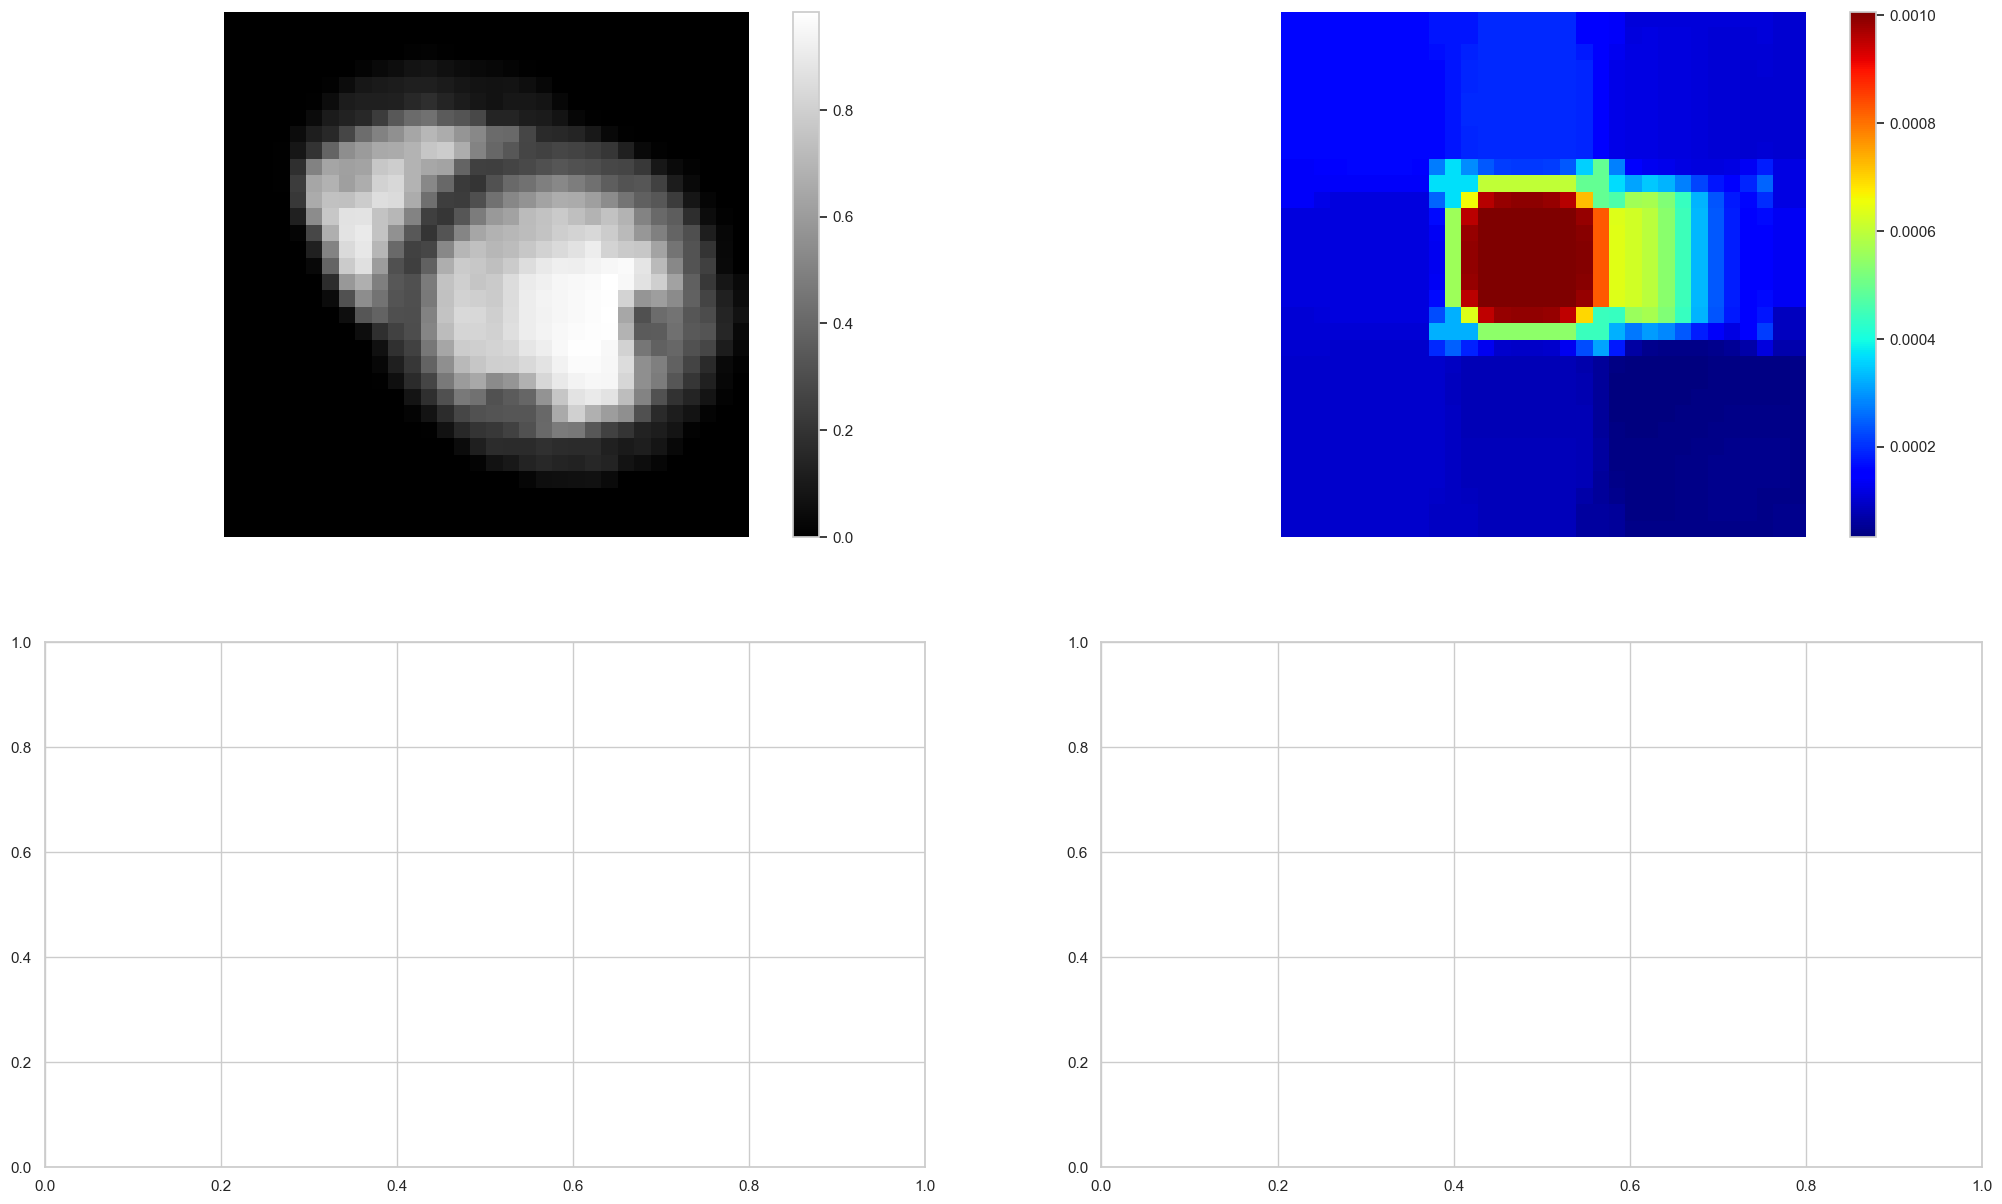

In [68]:
def plot_occlusion_heatmap(trainer, datamodule, depth_axis=-3, device=torch.device('cuda:0')):
    test_batch = next(iter(datamodule.val_dataloader()))
    img, label = test_batch['img'][:1], test_batch['label'][:1]
    img, label = img.to(device), label.unsqueeze(0).to(device)
    # Get the occlusion sensitivity map
    occ_sens = monai.visualize.OcclusionSensitivity(nn_module=trainer.model.to(device), mask_size=12, n_batch=10)
    # Only get a single slice to save time.
    # For the other dimensions (channel, width, height), use
    # -1 to use 0 and img.shape[x]-1 for min and max, respectively
    depth_slice = img.shape[depth_axis] // 2
    print(img.shape, depth_slice)
    occ_sens_b_box = [depth_slice - 1, depth_slice, -1, -1, -1, -1]

    occ_result, _ = occ_sens(x=img, b_box=occ_sens_b_box)
    print(occ_result.shape)
    occ_result = occ_result[0, label.argmax().item()][None]

    fig, axes = plt.subplots(1, 2, figsize=(25, 15), facecolor="white")

    for i, im in enumerate([img[:, :, depth_slice, ...], occ_result]):
        cmap = "gray" if i == 0 else "jet"
        ax = axes[i]
        im_show = ax.imshow(np.squeeze(im[0][0].detach().cpu()), cmap=cmap)
        ax.axis("off")
        fig.colorbar(im_show, ax=ax)

plot_occlusion_heatmap(trainer, datamodule)

## Comparative Analysis

[Compare the performance of your model(s) against the baseline model. Discuss any improvements or setbacks and the reasons behind them.]


In [ ]:
# Comparative Analysis code (if applicable)
# Kaggle results - how close do we get to the feature based approach?
print(f"Baseline Model Accuracy: {0.98}, New Model Accuracy: {0.80}")